## Шаг 1: Подготовка данных

### 1. Загрузка данных.

In [109]:
# Импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [8]:
#Создаём датафрейм
df = pd.read_csv('https://raw.githubusercontent.com/justmarkham/DAT8/refs/heads/master/data/chipotle.tsv', sep='\t',)

In [9]:
#Вывод первых пяти строк
df.head()

,order_id,quantity,item_name,choice_description,item_price
0,1,1,Chips and Fresh Tomato Salsa,NaN,$2.39
1,1,1,Izze,[Clementine],$3.39
2,1,1,Nantucket Nectar,[Apple],$3.39
3,1,1,Chips and Tomatillo-Green Chili Salsa,NaN,$2.39
4,2,2,Chicken Bowl,"[Tomatillo-Red Chili Salsa (Hot), [Black Beans...",$16.98


In [10]:
#Вывод шейпа
df.shape

(4622, 5)

### 2. Обработка пропусков

In [15]:
#Вывод количества Nan для каждой колонки
print(df.isnull().sum())

order_id                 0
quantity                 0
item_name                0
choice_description    1246
item_price               0
dtype: int64


In [17]:
#Замена Nan на более осознанный текст, в данном случае, что выбора нет
df['choice_description'].fillna('No Choice', inplace=True)

C:\Users\Deifo\AppData\Local\Temp\ipykernel_15316\728699212.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['choice_description'].fillna('No Choice', inplace=True)


In [19]:
#Вывод 10 строк для проверки
df.head(10)

,order_id,quantity,item_name,choice_description,item_price
0,1,1,Chips and Fresh Tomato Salsa,No Choice,$2.39
1,1,1,Izze,[Clementine],$3.39
2,1,1,Nantucket Nectar,[Apple],$3.39
3,1,1,Chips and Tomatillo-Green Chili Salsa,No Choice,$2.39
4,2,2,Chicken Bowl,"[Tomatillo-Red Chili Salsa (Hot), [Black Beans...",$16.98
5,3,1,Chicken Bowl,"[Fresh Tomato Salsa (Mild), [Rice, Cheese, Sou...",$10.98
6,3,1,Side of Chips,No Choice,$1.69
7,4,1,Steak Burrito,"[Tomatillo Red Chili Salsa, [Fajita Vegetables...",$11.75
8,4,1,Steak Soft Tacos,"[Tomatillo Green Chili Salsa, [Pinto Beans, Ch...",$9.25
9,5,1,Steak Burrito,"[Fresh Tomato Salsa, [Rice, Black Beans, Pinto...",$9.25


### 3. Приведение типов

In [22]:
#Вывод типов для каждой колонки
for col in df.columns:
    if df[col].dtype == 'object':
        print(f"Column '{col}' has object type.")
    elif df[col].dtype == 'int64':
        print(f"Column '{col}' has integer type.")
    elif df[col].dtype == 'float64':
        print(f"Columg '{col}' has float type.")
    else:
        print(f"Column '{col}' has unexpected type.")

Column 'order_id' has integer type.
Column 'quantity' has integer type.
Column 'item_name' has object type.
Column 'choice_description' has object type.
Column 'item_price' has object type.


In [24]:
#Привидение колонки item_price во float с удалением знака $
df = df.astype(dtype={'item_price': 'string'})
df['item_price'] = df['item_price'].str.replace('$', '')
df['item_price'] = pd.to_numeric(df['item_price'], errors='coerce')

In [26]:
#Переименовывание колонки
df.rename(columns={'item_price': 'item_price ($)'}, inplace=True)

In [28]:
#Проверка, что имя изменилось
df.columns

Index(['order_id', 'quantity', 'item_name', 'choice_description',
       'item_price ($)'],
      dtype='object')

In [30]:
#Проверка типа колонки после изменения 
df['item_price ($)'].head()

0     2.39
1     3.39
2     3.39
3     2.39
4    16.98
Name: item_price ($), dtype: Float64

## Шаг 2: Анализ данных

### 1. Общий анализ.

In [34]:
# Группировка и подсчёт количества уникальных значений
grouped_df = df.groupby('item_name')['order_id'].nunique().reset_index(name='count_orders')

# Вывод товара с минимальным количеством уникальных заказов
most_unique_item = grouped_df.loc[grouped_df['count_orders'] == grouped_df['count_orders'].min()]
# Вывод товара с максимальным количеством уникальных заказов
most_popular_item = grouped_df.loc[grouped_df['count_orders'] == grouped_df['count_orders'].max()]
print('Most popular: \n')
print(f'{most_popular_item} \n')
print('Most unique: \n')
print(f'{most_unique_item}')

Most popular: 

       item_name  count_orders
17  Chicken Bowl           615 

Most unique: 

                            item_name  count_orders
14                     Carnitas Salad             1
26  Chips and Mild Fresh Tomato Salsa             1
33                       Crispy Tacos             1
36                              Salad             1
46                Veggie Crispy Tacos             1


### 2. Суммарный анализ

In [37]:
# Рассчитываем общую выручку для каждого заказа
df['total_revenue'] = df['quantity'] * df['item_price ($)']

revenue_by_item = df.groupby('item_name')['total_revenue'].sum().reset_index()

print('The amount of revenue for each product: \n')
print(revenue_by_item, '\n')


# Сортируем по убыванию, чтобы выбрать первые 5 товаров
top_5_items = revenue_by_item.sort_values(by='total_revenue', ascending=False).head(5)

print('Top 5 products by revenue: \n')
print(top_5_items)

The amount of revenue for each product: 

                                item_name  total_revenue
0                       6 Pack Soft Drink         369.93
1                           Barbacoa Bowl         672.36
2                        Barbacoa Burrito         894.75
3                   Barbacoa Crispy Tacos         138.71
4                     Barbacoa Salad Bowl          106.4
5                     Barbacoa Soft Tacos         250.46
6                           Bottled Water         649.18
7                                    Bowl           74.0
8                                 Burrito           44.4
9                             Canned Soda         191.84
10                      Canned Soft Drink         603.75
11                          Carnitas Bowl         830.71
12                       Carnitas Burrito         616.33
13                  Carnitas Crispy Tacos          95.94
14                         Carnitas Salad           8.99
15                    Carnitas Salad Bowl     

### 3. Группировка данных (groupby)

In [40]:
# Группируем по названию товара и считаем количество уникальных заказов
orders_by_item = df.groupby('item_name')['order_id'].nunique().reset_index(name='total_orders')

print(orders_by_item)

                                item_name  total_orders
0                       6 Pack Soft Drink            54
1                           Barbacoa Bowl            61
2                        Barbacoa Burrito            88
3                   Barbacoa Crispy Tacos            11
4                     Barbacoa Salad Bowl             9
5                     Barbacoa Soft Tacos            25
6                           Bottled Water           154
7                                    Bowl             2
8                                 Burrito             4
9                             Canned Soda            94
10                      Canned Soft Drink           276
11                          Carnitas Bowl            67
12                       Carnitas Burrito            58
13                  Carnitas Crispy Tacos             7
14                         Carnitas Salad             1
15                    Carnitas Salad Bowl             6
16                    Carnitas Soft Tacos       

In [42]:
# Рассчитываем общую выручку для каждого заказа
df['total_revenue'] = df['quantity'] * df['item_price ($)']

# Группируем по названию товара и рассчитываем средние показатели
average_order_value = (
    df.groupby('item_name')[['total_revenue', 'order_id']]
      .agg({'total_revenue': 'sum', 'order_id': 'nunique'})
      .assign(average_order_value=lambda x: x['total_revenue'] / x['order_id'])
      .reset_index()
)

print(average_order_value)

                                item_name  total_revenue  order_id  \
0                       6 Pack Soft Drink         369.93        54   
1                           Barbacoa Bowl         672.36        61   
2                        Barbacoa Burrito         894.75        88   
3                   Barbacoa Crispy Tacos         138.71        11   
4                     Barbacoa Salad Bowl          106.4         9   
5                     Barbacoa Soft Tacos         250.46        25   
6                           Bottled Water         649.18       154   
7                                    Bowl           74.0         2   
8                                 Burrito           44.4         4   
9                             Canned Soda         191.84        94   
10                      Canned Soft Drink         603.75       276   
11                          Carnitas Bowl         830.71        67   
12                       Carnitas Burrito         616.33        58   
13                  

## 3: Визуализация данных

### 1. График популярности товаров

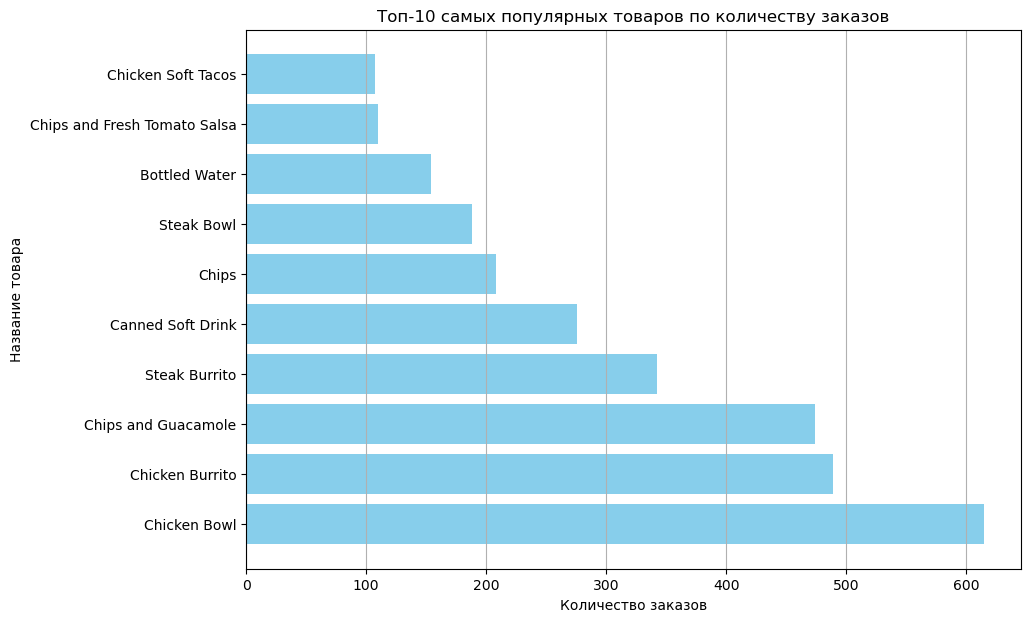

In [46]:
# Группируем по названию товара и считаем количество уникальных заказов
orders_by_item = df.groupby('item_name')['order_id'].nunique().reset_index(name='total_orders')

# Сортируем товары по количеству заказов в порядке убывания и выбираем топ-10
top_10_items = orders_by_item.sort_values(by='total_orders', ascending=False).head(10)

# Строим горизонтальный столбчатый график
plt.figure(figsize=(10, 7))
plt.barh(y=top_10_items['item_name'], width=top_10_items['total_orders'], color='skyblue')
plt.xlabel('Количество заказов')
plt.ylabel('Название товара')
plt.title('Топ-10 самых популярных товаров по количеству заказов')
plt.grid(axis='x')
plt.show()

### 2. Распределение цен

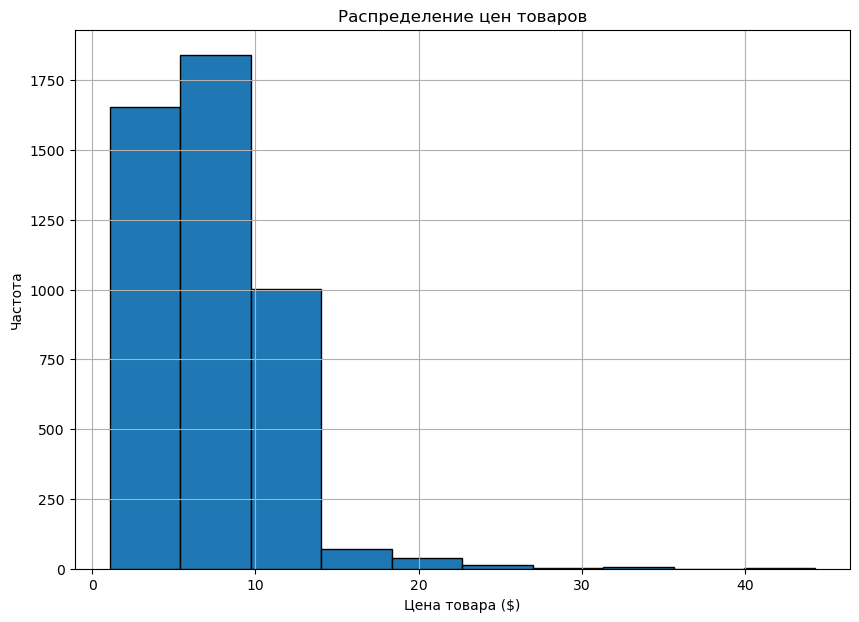

In [49]:
#Используем библиотеку matplolib
plt.figure(figsize=(10, 7))
plt.hist(df['item_price ($)'], bins=10, edgecolor='black')
plt.xlabel('Цена товара ($)')
plt.ylabel('Частота')
plt.title('Распределение цен товаров')
plt.grid(True)
plt.show()

## 4: Продвинутый анализ

### 1. Квантильная категоризация (qcut)

In [55]:
# Рассчитываем среднюю цену для каждого товара
mean_prices = df.groupby('item_name')['item_price ($)'].mean().reset_index()

# Квантильная категоризация
categories = pd.qcut(mean_prices['item_price ($)'], q=[0, 0.25, 0.5, 0.75, 1], labels=['Low', 'Medium', 'High', 'Very High'])

# Присваиваем категории каждому товару
mean_prices['category'] = categories

# Количество товаров в каждой категории
category_counts = mean_prices['category'].value_counts()

print(category_counts)

category
Low          13
Very High    13
Medium       12
High         12
Name: count, dtype: int64


In [68]:
df.head(20)

,order_id,quantity,item_name,choice_description,item_price ($),total_revenue
0,1,1,Chips and Fresh Tomato Salsa,No Choice,2.39,2.39
1,1,1,Izze,[Clementine],3.39,3.39
2,1,1,Nantucket Nectar,[Apple],3.39,3.39
3,1,1,Chips and Tomatillo-Green Chili Salsa,No Choice,2.39,2.39
4,2,2,Chicken Bowl,"[Tomatillo-Red Chili Salsa (Hot), [Black Beans...",16.98,33.96
5,3,1,Chicken Bowl,"[Fresh Tomato Salsa (Mild), [Rice, Cheese, Sou...",10.98,10.98
6,3,1,Side of Chips,No Choice,1.69,1.69
7,4,1,Steak Burrito,"[Tomatillo Red Chili Salsa, [Fajita Vegetables...",11.75,11.75
8,4,1,Steak Soft Tacos,"[Tomatillo Green Chili Salsa, [Pinto Beans, Ch...",9.25,9.25
9,5,1,Steak Burrito,"[Fresh Tomato Salsa, [Rice, Black Beans, Pinto...",9.25,9.25


### 2. Сводная таблица (pivot)

In [70]:
# Создание сводной таблицы
pivot_table = pd.pivot_table(
    data=df,
    index='item_name',
    values=['order_id', 'total_revenue'],
    aggfunc={
        'order_id': 'count',
        'total_revenue': 'sum'
    }
)

# Добавление среднего значения стоимости заказа
pivot_table['avg_order_value'] = pivot_table['total_revenue'] / pivot_table['order_id']

# Переносим индексы в отдельные столбцы
pivot_table.reset_index(inplace=True)

# Форматируем значения
pivot_table['order_id'] = pivot_table['order_id'].astype(int)
pivot_table['total_revenue'] = pivot_table['total_revenue'].map('${:,.2f}'.format)
pivot_table['avg_order_value'] = pivot_table['avg_order_value'].map('${:.2f}'.format)

# Показываем итоговую сводную таблицу
print(pivot_table)

                                item_name  order_id total_revenue  \
0                       6 Pack Soft Drink        54       $369.93   
1                           Barbacoa Bowl        66       $672.36   
2                        Barbacoa Burrito        91       $894.75   
3                   Barbacoa Crispy Tacos        11       $138.71   
4                     Barbacoa Salad Bowl        10       $106.40   
5                     Barbacoa Soft Tacos        25       $250.46   
6                           Bottled Water       162       $649.18   
7                                    Bowl         2        $74.00   
8                                 Burrito         6        $44.40   
9                             Canned Soda       104       $191.84   
10                      Canned Soft Drink       301       $603.75   
11                          Carnitas Bowl        68       $830.71   
12                       Carnitas Burrito        59       $616.33   
13                  Carnitas Crisp

## 5: Применение машинного обучения

### 1. Подготовка данных.

In [82]:
# Рассчитываем среднюю цену для каждого товара
mean_prices = df.groupby('item_name')['item_price ($)'].mean().reset_index()

# Рассчитываем общее количество заказов для каждого товара
orders_by_item = df.groupby('item_name')['order_id'].nunique().reset_index()

# Формируем обучающую выборку
training_data = mean_prices.merge(orders_by_item, on='item_name')

# Формируем целевую переменную
target_variable = df.groupby('item_name')['total_revenue'].sum().reset_index()

# Объединяем с целевой переменной
training_data = training_data.merge(target_variable, on='item_name')

# Показываем обучающую выборку
print(training_data)

                                item_name  item_price ($)  order_id  \
0                       6 Pack Soft Drink        6.610185        54   
1                           Barbacoa Bowl       10.187273        61   
2                        Barbacoa Burrito        9.832418        88   
3                   Barbacoa Crispy Tacos       10.928182        11   
4                     Barbacoa Salad Bowl           10.64         9   
5                     Barbacoa Soft Tacos         10.0184        25   
6                           Bottled Water        1.867654       154   
7                                    Bowl            14.8         2   
8                                 Burrito             7.4         4   
9                             Canned Soda        1.320577        94   
10                      Canned Soft Drink        1.457641       276   
11                          Carnitas Bowl       10.833971        67   
12                       Carnitas Burrito       10.132712        58   
13    

### 2. Обучение модели.

In [101]:
# Определение признаков и целевой переменной
X = df[['quantity', 'item_price ($)']]  # Признаки
y = df['total_revenue']                 # Целевая переменная

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [103]:
# Создание и обучение модели линейной регрессии
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [105]:
# Предсказание значений на тестовой выборке
y_pred = model.predict(X_test)

In [111]:
# Вычисление метрик качества модели
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse:.2f}')
print(f'R²: {r2:.2f}')

MSE: 10.08
R²: 0.85
